In [1]:
import json
import string
from IPython.display import JSON
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud,STOPWORDS
import re
import os
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle

# 1. Dataset Exploration and Cleaning

In [2]:
# Load the JSON data from the file
with open('products.json', 'r') as f:
    data = json.load(f)

print("Total dataset is " + str(len(data)))

Total dataset is 51646


In [3]:
# Convert the data to a JSONable dictionary or list
json_data = data[:100]
print(json.dumps(json_data, indent=4))

[
    {
        "sku": 43900,
        "name": "Duracell - AAA Batteries (4-Pack)",
        "type": "HardGood",
        "price": 5.49,
        "upc": "041333424019",
        "category": [
            {
                "id": "pcmcat312300050015",
                "name": "Connected Home & Housewares"
            },
            {
                "id": "pcmcat248700050021",
                "name": "Housewares"
            },
            {
                "id": "pcmcat303600050001",
                "name": "Household Batteries"
            },
            {
                "id": "abcat0208002",
                "name": "Alkaline Batteries"
            }
        ],
        "shipping": 5.49,
        "description": "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack",
        "manufacturer": "Duracell",
        "model": "MN2400B4Z",
        "url": "http://www.bestbuy.com/site/duracell-aaa-batteries-4-pack/43900.p?id=1051384074145&skuId=43900&cmp=RMXCC"

We are interested in only "name, description, category".
<p>We need only 1 category per product.</p> 
<p>The category is arranged in order of increasing specificity, from the broadest to the most detailed. </p>

In [4]:
def get_dataframe(data):
    column_names = ['name', 'description', 'category']
    large_cats = ['Appliances', 'Cell Phones', 'Audio']
    names, descriptions, categories = [], [], []

    for product in data:
        names.append(product['name'])
        descriptions.append(product['description'])
        
        if len(product['category']) > 1:
            categories.append(product['category'][1]['name'])
        else:
            categories.append(product['category'][0]['name'])
  
    df = pd.DataFrame(list(zip(names, descriptions, categories)), columns=column_names)
    return df

df = get_dataframe(data)


Check how the data frame look like

In [5]:
cat = pd.DataFrame(df) 
cat.head(10)

,name,description,category
0,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,Housewares
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,Housewares
2,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,Housewares
3,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,Housewares
4,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,Housewares
5,Duracell - D Batteries (4-Pack),Compatible with select electronic devices; D s...,Housewares
6,Duracell - 9V Batteries (2-Pack),Compatible with select electronic devices; alk...,Housewares
7,Directed Electronics - Viper Audio Glass Break...,From our expanded online assortment; compatibl...,Carfi Instore Only
8,Energizer - N Cell E90 Batteries (2-Pack),Alkaline batteries; 1.5V,Housewares
9,Metra - Radio Installation Dash Kit for Most 1...,From our expanded online assortment; compatibl...,Car Installation Parts & Accessories


Count frequency of categories in dataset with only categories with dataset frequency >= 500

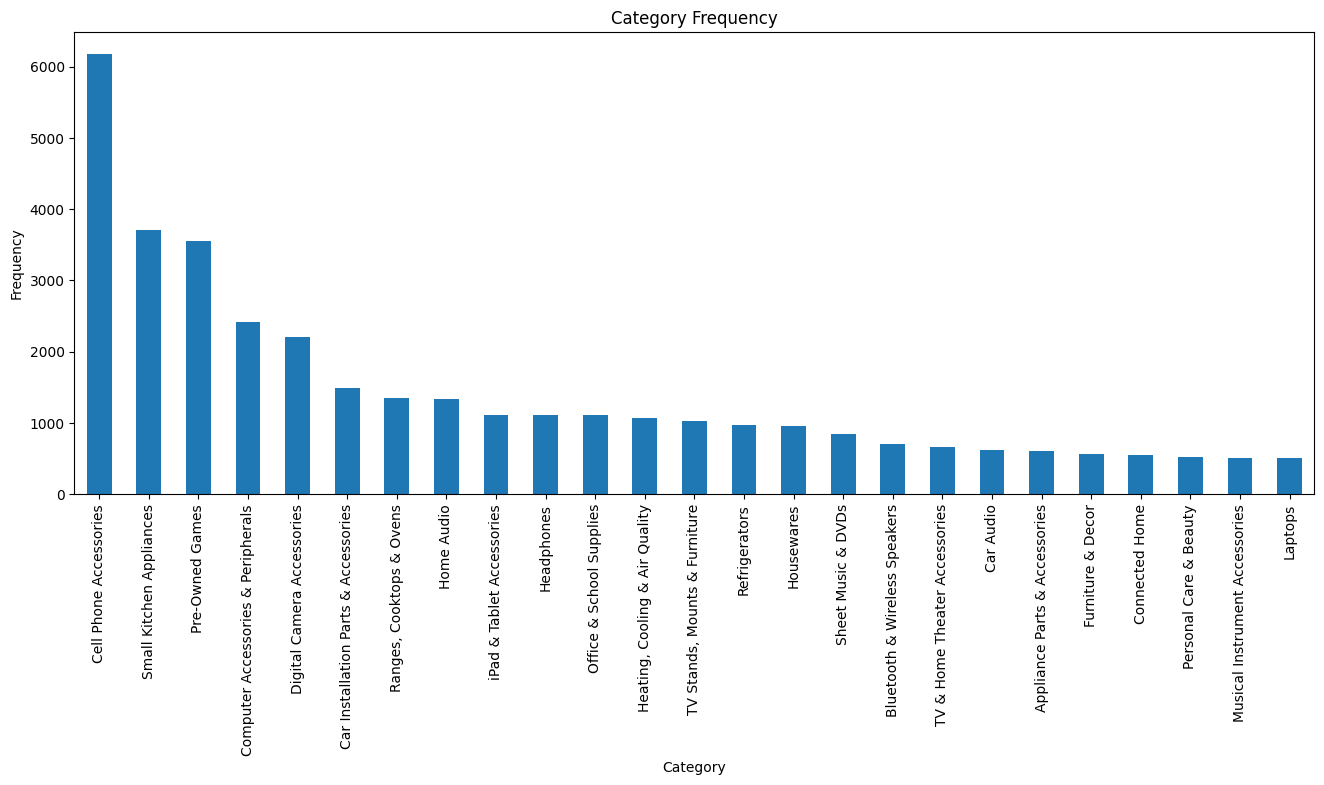

In [6]:
category_counts = df['category'].value_counts()
category_counts = category_counts[category_counts >= 500]
df_cleaned = df[df['category'].isin(category_counts.index)]
plt.figure(figsize=(16, 6))

category_counts.plot(kind='bar')


plt.title('Category Frequency')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

display(pd.DataFrame(category_counts))

,category
Cell Phone Accessories,6176
Small Kitchen Appliances,3708
Pre-Owned Games,3556
Computer Accessories & Peripherals,2414
Digital Camera Accessories,2201
Car Installation Parts & Accessories,1491
"Ranges, Cooktops & Ovens",1345
Home Audio,1334
iPad & Tablet Accessories,1117
Headphones,1116


In [8]:
df_cleaned.shape

(35701, 3)

In [9]:
df_cleaned.head()

,name,description,category
0,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,Housewares
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,Housewares
2,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,Housewares
3,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,Housewares
4,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,Housewares


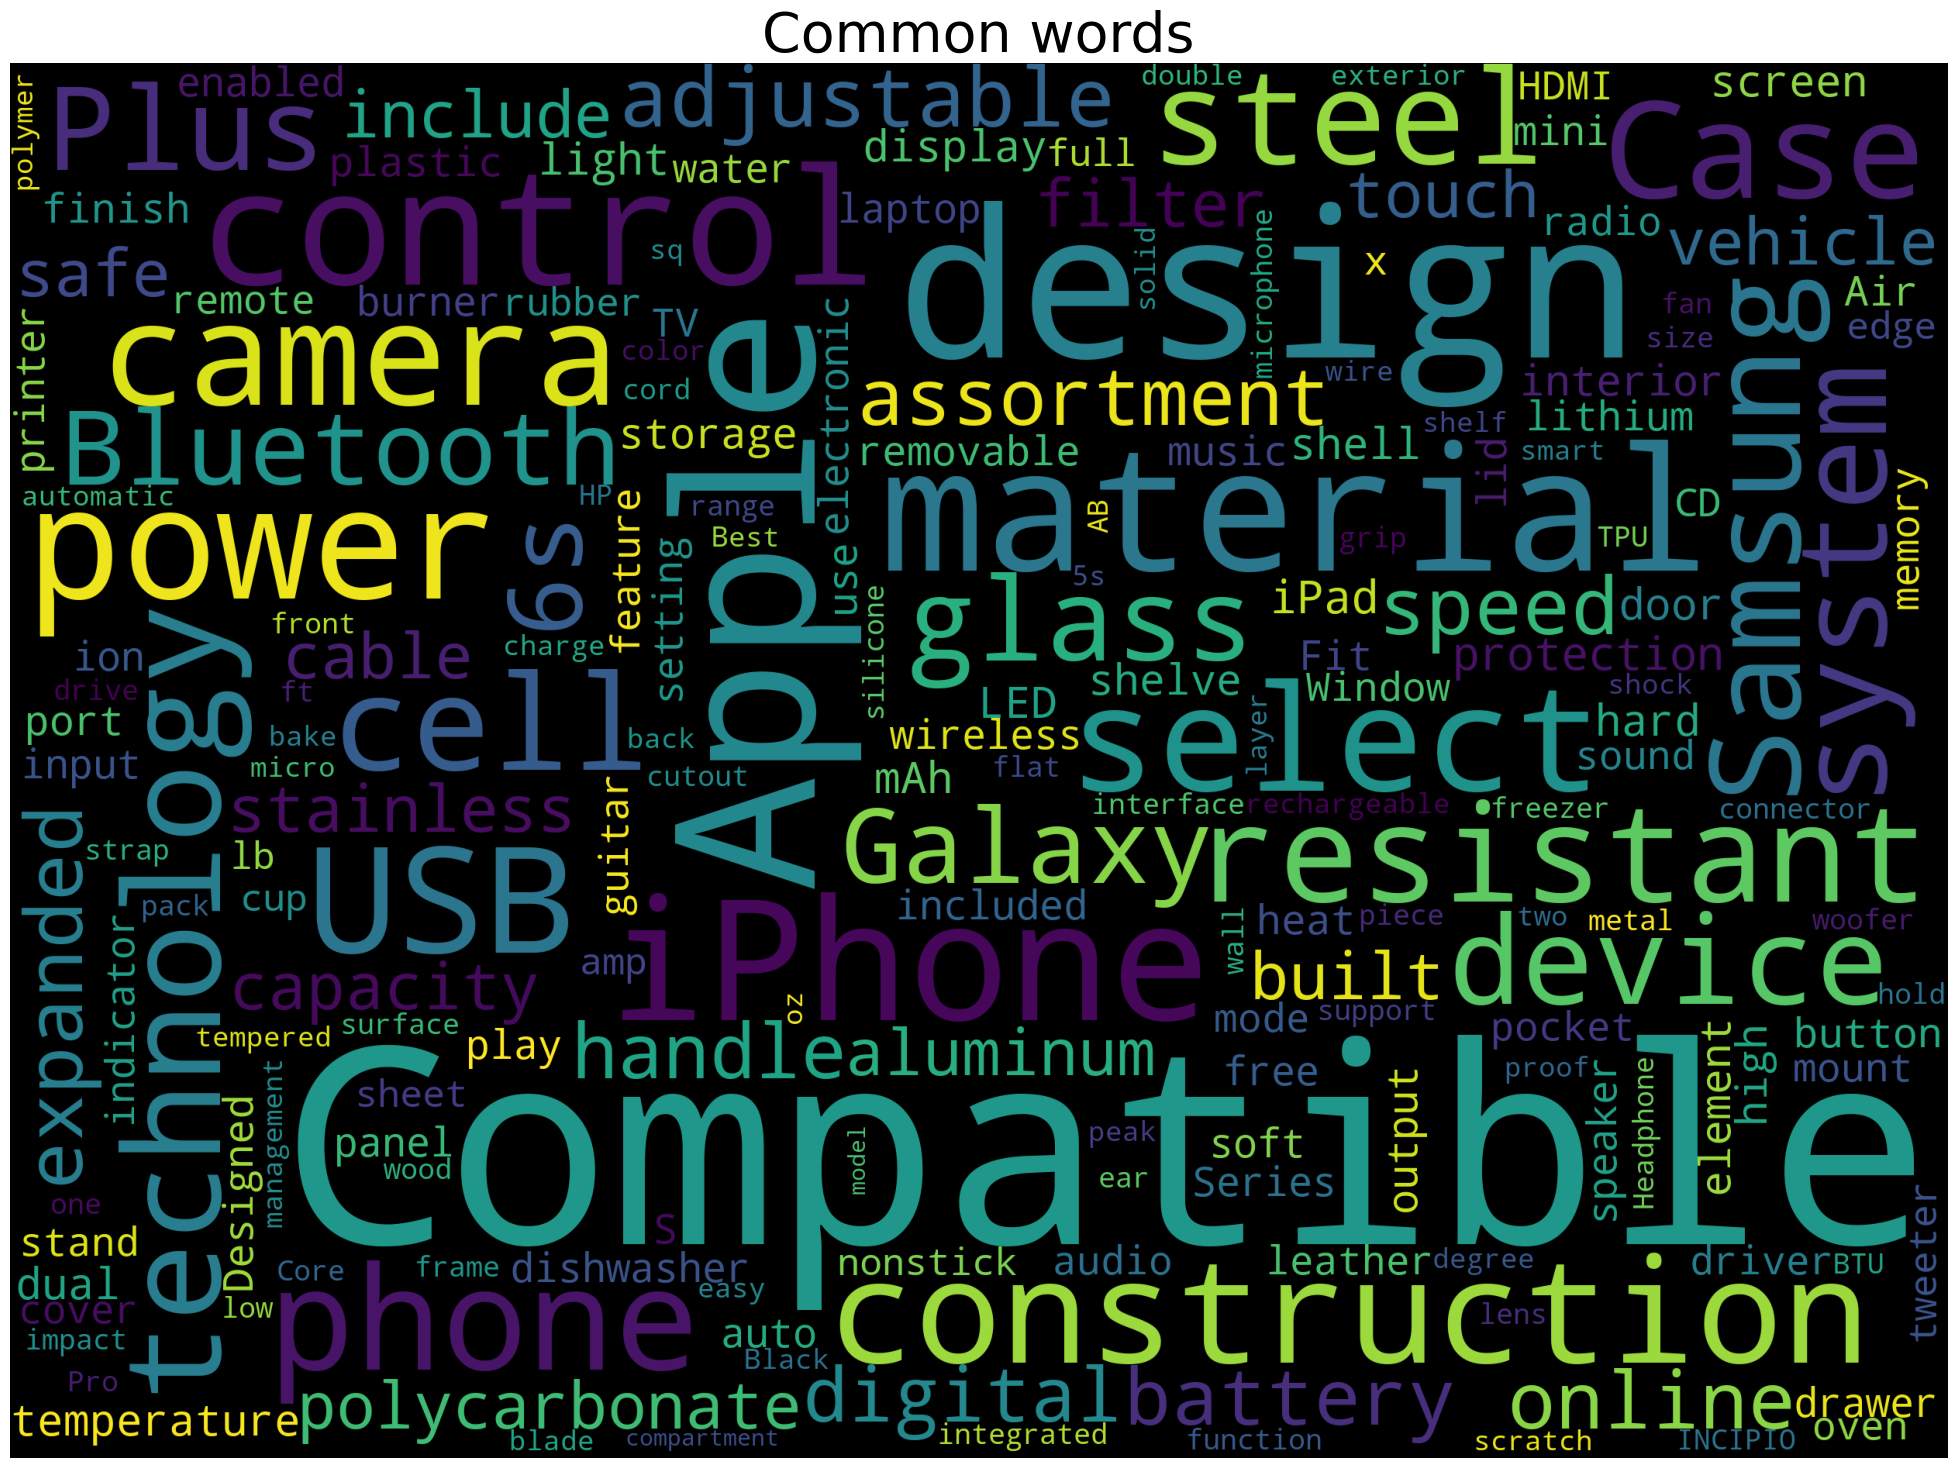

In [10]:
plt.figure(figsize=(25,25))
text = df_cleaned.description.values
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='black',
                  collocations=False,
                  width=2500,
                  height=1800
                  ).generate(" ".join(text))
plt.axis('off')
plt.title("Common words",fontsize=40)
plt.imshow(cloud)

In [11]:
# Utility function for data cleaning, natural language processing concepts

def clean_punc(sentence):
    translator = str.maketrans('', '', string.punctuation)
    cleaned_text = sentence.translate(translator)
    return cleaned_text

def keep_alpha(sentence):
    return re.sub(r'[^a-zA-Z\s]+', '', sentence)

ssl._create_default_https_context = ssl._create_unverified_context
nltk.data.path.append(os.path.join(os.getcwd(), "nltk_data"))
# download the necessary resources
nltk.download('stopwords', download_dir="nltk_data")
nltk.download('punkt', download_dir="nltk_data")

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    filtered_text = [word for word in word_tokens if not word.lower() in stop_words]
    return ' '.join(filtered_text)



stemmer = SnowballStemmer("english")
def stemming(sentence):
    sentence = str(sentence)
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence




[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Combine 'name' and 'description' features into one feature 'information' and apply the cleaning methods

In [12]:
# Applying data cleaning on description to ignore irrelevant words

df_cleaned = df_cleaned.assign(information=lambda x: x['name'] + ' ' + x['description']).drop(['name', 'description'], axis=1)
df_cleaned.head(100)

,category,information
0,Housewares,Duracell - AAA Batteries (4-Pack) Compatible w...
1,Housewares,Duracell - AA 1.5V CopperTop Batteries (4-Pack...
2,Housewares,Duracell - AA Batteries (8-Pack) Compatible wi...
3,Housewares,Energizer - MAX Batteries AA (4-Pack) 4-pack A...
4,Housewares,Duracell - C Batteries (4-Pack) Compatible wit...
5,Housewares,Duracell - D Batteries (4-Pack) Compatible wit...
6,Housewares,Duracell - 9V Batteries (2-Pack) Compatible wi...
8,Housewares,Energizer - N Cell E90 Batteries (2-Pack) Alka...
9,Car Installation Parts & Accessories,Metra - Radio Installation Dash Kit for Most 1...
10,Car Installation Parts & Accessories,Metra - Radio Dash Multikit for Select GM Vehi...


In [13]:
df_cleaned.loc[:, 'information'] = df_cleaned['information'].str.lower()
df_cleaned.loc[:, 'information'] = df_cleaned['information'].apply(keep_alpha)
df_cleaned.loc[:, 'information'] = df_cleaned['information'].apply(remove_stopwords)
df_cleaned.loc[:, 'information'] = df_cleaned['information'].apply(stemming)

In [14]:
df_cleaned.head(100)

,category,information
0,Housewares,duracel aaa batteri pack compat select electro...
1,Housewares,duracel aa v coppertop batteri pack longlast e...
2,Housewares,duracel aa batteri pack compat select electron...
3,Housewares,energ max batteri aa pack pack aa alkalin batt...
4,Housewares,duracel c batteri pack compat select electron ...
5,Housewares,duracel batteri pack compat select electron de...
6,Housewares,duracel v batteri pack compat select electron ...
8,Housewares,energ n cell e batteri pack alkalin batteri v
9,Car Installation Parts & Accessories,metra radio instal dash kit ford lincoln mercu...
10,Car Installation Parts & Accessories,metra radio dash multikit select gm vehicl bla...


# 2. Model Training

In [15]:
def fit_model(X_train, y_train, classifier):
    model_path = f'model_{type(classifier).__name__}.pkl'
    # Check if model file already exists and delete it
    if os.path.exists(model_path):
        os.remove(model_path)    
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
    X_train_tf = vectorizer.fit_transform(X_train)
    classifier.fit(X_train_tf, y_train)
    # Save the model to a file
    with open(model_path, 'wb') as f:
        pickle.dump((classifier, vectorizer), f)
    return classifier, vectorizer



In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['information'], 
                                                        df_cleaned['category'], 
                                                        test_size=0.2, 
                                                        random_state=0, 
                                                        shuffle=True)

# 3. Model Evaluation

In [18]:
svm_classifier, svm_vectorizer = fit_model(X_train, y_train, LinearSVC())
    
X_test_tf = svm_vectorizer.transform(X_test)
y_pred = svm_classifier.predict(X_test_tf)
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy: ", accuracy)

nb_classifier, nb_vectorizer = fit_model(X_train, y_train, MultinomialNB())
X_test_tf = nb_vectorizer.transform(X_test)
y_pred = nb_classifier.predict(X_test_tf.toarray())
accuracy = accuracy_score(y_test, y_pred)
print("Naive Bayes Accuracy: ", accuracy)

lr_classifier, lr_vectorizer = fit_model(X_train, y_train, LogisticRegression(max_iter=500))
X_test_tf = lr_vectorizer.transform(X_test)
y_pred = lr_classifier.predict(X_test_tf)
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy: ", accuracy)

SVM Accuracy:  0.9777342108948327
Naive Bayes Accuracy:  0.8862904355132334
Logistic Regression Accuracy:  0.9621901694440554
